In [1]:
import numpy as np

In [2]:
arr = np.load('MAPS.npy')

#Creating Piano roll from 2D boolean array
arr2 = np.empty((20426, 88), dtype = int) 
for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
        if arr[i,j]==False:
            arr2[i,j]=int(0)
            int(arr2[i,j])
        elif arr[i,j]==True:
            arr2[i,j]=int(1)

arr3 = np.zeros((88,20426,2), dtype=int)

start=1
k=0 

#Array to store the start and end times of each note played in key 
for j in range(arr2.shape[1]):
    for i in range(arr2.shape[0]):
        if arr2[i,j]==1 and start==1:
            arr3[j,k,0]=i
            start=0
        elif arr2[i,j]==0 and start==0:
            arr3[j,k,1]=i
            start=1
            k+=1
    k=0

#Array to store the end times of each key 
arr4=np.zeros((88), dtype=int)
for i in range(arr3.shape[0]):
  for j in range(arr3.shape[1]):
    if arr3[i,j,0]==0:
      arr4[i]=j
      break

In [3]:
!pip install midiutil
from midiutil.MidiFile import MIDIFile

     |████████████████████████████████| 1.0 MB 28.9 MB/s 
  Created wheel for midiutil: filename=MIDIUtil-1.2.1-py3-none-any.whl size=54566 sha256=727ac86e3c8d46ea173dc256b4ba2ede376e9b1046ac3d49ee6b7d3595386d2a
  Stored in directory: /root/.cache/pip/wheels/e3/97/cd/a677b61a76d575f373e2e10302f1d9106507fea6dd1320df03
Successfully built midiutil


In [4]:
!pip install pretty_midi

import pretty_midi
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd

     |████████████████████████████████| 5.6 MB 21.2 MB/s 
     |████████████████████████████████| 51 kB 6.9 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=49f7b62ed3fe7cc42442c3758b773a23fcdd8031d4c8fb0fd604429070c21af3
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [12]:
#Converts MIDI file to a dataframe using pretty_MIDI and using Matplotlib to get piano roll representation

def pianoroll(path,plot):
  midi_data = pretty_midi.PrettyMIDI(path)
  midi_list = []

  pretty_midi.pretty_midi.MAX_TICK = 1e10
  midi_data.tick_to_time(14325216)

  for instrument in midi_data.instruments:
      for note in instrument.notes:
          start = note.start
          end = note.end
          pitch = note.pitch
          velocity = note.velocity
          midi_list.append([start, end, pitch, velocity, instrument.name])
          
  midi_list = sorted(midi_list, key=lambda x: (x[0], x[2]))

  df = pd.DataFrame(midi_list, columns=['Start', 'End', 'Pitch', 'Velocity', 'Instrument'])

  time_list = df["End"].tolist()
  rows = len(time_list)

  if plot==True :

    fig, ax = plt.subplots()

    i = 0
    while(i<rows) :
        start = float(midi_list[i][0])
        pitch = float(midi_list[i][2])
        duration = float(midi_list[i][1]-midi_list[i][0])

        rect = matplotlib.patches.Rectangle((start, pitch),duration, 1, color='black', linewidth=1)
        ax.add_patch(rect)
        i+=1
        
    plt.xlim([0, 240])
    plt.ylim([0, 88])

    plt.grid(color='grey',linewidth=1)

    plt.show()
  
  stop_time=time_list[-1]
  return stop_time

In [18]:
stop_time= pianoroll("MAPS.mid", False)
t= float(stop_time)/float(np.shape(arr)[0])
print(t)

0.011602873972352394


In [15]:
def arr_to_midi(source_array,duration_array):
  mf = MIDIFile(1)
  track = 0   
  time = 0
  channel = 0
  volume = 100
  delta =t
  mf.addTrackName(track, time, "Output")
  mf.addTempo(track, time, 60)

  for i in range(source_array.shape[0]):
    for j in range(duration_array[i]):
              pitch = i +21
              time = delta*source_array[i,j,0]
              duration = delta*( source_array[i,j,1] - source_array[i,j,0] ) 
              mf.addNote(track, channel, pitch, time, duration, volume)

  with open("output.mid", 'wb') as outf:
      mf.writeFile(outf)

In [16]:
arr_to_midi(arr3,arr4)

GENERATED


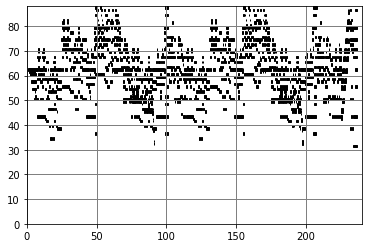

ACTUAL


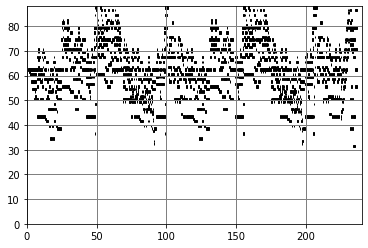

237.00030375927003

In [17]:
#Comparing actual and obtained MIDI files

print("GENERATED")
pianoroll("output.mid", True)
print("ACTUAL")
pianoroll("MAPS.mid",True)
